In [1]:
import numpy as np
#from arch import arch_model
import numpy as np
from scipy import optimize
from scipy.stats import norm
from scipy import special
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt

## Read in data

In [11]:
import pandas as pd

In [12]:
daily_sp500_returns = pd.read_fwf("daily_sp500_ret.txt").to_numpy()[4:]
monthly_sp500_returns = pd.read_fwf("monthly_sp500_ret.txt").to_numpy()[4:]

In [13]:
sp500_monthly_garch_model_11 = arch_model(monthly_sp500_returns[:,1], vol='Garch', p=1, o=0, q=1)
sp500_monthly_garch_fitted = monthly_garch_model_11.fit()

NameError: name 'monthly_garch_model_11' is not defined

In [ ]:
sp500_monthly_garch_fitted.params

# Problem 4

In [15]:
monthly_yields = pd.read_csv("1month_tbill_daily.csv")
monthly_yields = pd.Series.dropna(monthly_yields["NFCP_M1"])
monthly_yields = monthly_yields.values

In [3]:
def simulate_euler_CIR(kappa, theta, sigma2, nsteps):
    dt = 1/250.0
    rates = np.zeros(nsteps)
    rates[0] = theta
    noise = np.random.normal(0, np.sqrt(dt), size=nsteps)
    for t in range(1, nsteps):
        rates[t] = abs(rates[t-1] + kappa*(theta - rates[t-1])*dt + np.sqrt(sigma2*rates[t-1])*noise[t])
    return rates

In [4]:
rates = simulate_euler_CIR(kappa=0.234, theta=0.081, sigma2=0.0073, nsteps=100000)

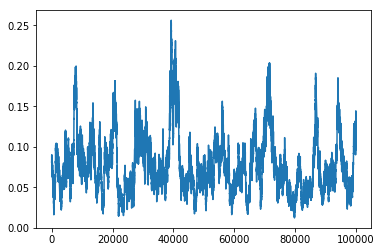

In [5]:
plt.plot(rates)

In [6]:
monthly_rates = rates[::250]
monthly_rates.shape

(400,)

$$\epsilon_{k+1} - E{\epsilon_{k+1}|F_k} = 0$$
$$r_{k+1} - r_k - \kappa(\theta - r_t) \delta_k = 0$$

In [7]:

# define moment functions

def g1(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[1:] - data[:-1] - kappa*(theta - data[:-1])*dt

def g2(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[:-1]*g1(pv, data)

def g3(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return (g1(pv, data))**2 - sig2*data[:-1]*dt

def g4(pv, data, dt=1):
    theta, kappa, sig2 = pv
    return data[:-1] * g3(pv, data) - sig2*(data[:-1]**2)*dt

In [8]:
def GMM(moments, param_vect, data, n_iter=1):
    results = []
    W = np.eye(len(moments))
    
    def G(W):
        def inner(pv):
            moment_means = np.mean(np.array([g(pv, data) for g in moments]), axis=1)
            retval = moment_means @ W @ moment_means
            return retval
        return inner
    
    res = optimize.minimize(G(W), x0 = param_vect, method = 'BFGS', tol = 1.e-9)
    
    res = res.x
    results.append(res.copy())
    for _ in range(n_iter):
        
        S = np.zeros_like(W)
        for t in range(data.shape[0]-1):
            moments_t = np.array([g(res, data[t:t+2]) for g in moments])
            
            S += np.outer(moments_t, moments_t)
        S /= (data.shape[0]-1)
        moment_means = np.array([np.mean(g(res, data)) for g in moments])
        S -= np.outer(moment_means, moment_means)
        W = np.linalg.inv(S)
        res = optimize.minimize(G(W), x0 = param_vect, method = 'BFGS', tol = 1.e-9)
        res=res.x
        results.append(res.copy())
    return results

In [9]:
theta_init = 0.1 #np.mean(monthly_rates)
kappa_init = 0.1 #0.234
sig2_init = 0.1 #0.0073
opt_input = [theta_init, kappa_init, sig2_init]

In [10]:
results = GMM([g1, g2, g3, g4], opt_input, monthly_rates, n_iter=10)

In [11]:
results

[array([0.07611894, 0.20156168, 0.00605917]),
 array([0.06501008, 0.23971576, 0.00194293]),
 array([ 0.0595778 ,  0.28298299, -0.00051742]),
 array([ 0.05724879,  0.27692396, -0.00045305]),
 array([ 0.05642657,  0.27558337, -0.00045843]),
 array([ 0.05614622,  0.2748859 , -0.0004519 ]),
 array([ 0.05605377,  0.27471349, -0.00045176]),
 array([ 0.05602303,  0.27464076, -0.00045119]),
 array([ 0.05601295,  0.27462071, -0.00045113]),
 array([ 0.05600962,  0.27461311, -0.00045108]),
 array([ 0.05600852,  0.27461085, -0.00045107])]

In [16]:
# now try with tbill data
results = GMM([g1, g2, g3, g4], opt_input, monthly_yields, n_iter=10)
results

[array([4.58711286e-01, 3.70246140e-04, 2.80852430e-04]),
 array([ 0.08463005, -0.00073534, -0.00018813]),
 array([-0.03067354, -0.00074474, -0.00018424]),
 array([-0.04041045, -0.0007446 , -0.00018447]),
 array([-0.04119372, -0.00074453, -0.00018446]),
 array([-0.04124892, -0.00074452, -0.00018446]),
 array([-0.0412564 , -0.00074452, -0.00018446]),
 array([-0.04124893, -0.00074452, -0.00018446]),
 array([-0.04125   , -0.00074452, -0.00018446]),
 array([-0.04125073, -0.00074452, -0.00018446]),
 array([-0.04119495, -0.00074452, -0.00018446])]

In [12]:
def QML_G(data):
    def qml(pv):
        theta, kappa, sig2 = pv
        lik = 0
        for i in range(data.shape[0]-1):
            lik += norm.logpdf(data[i + 1], data[i] + kappa*(theta - data[i]), 
                        np.sqrt(abs(sig2) * data[i]))
        return -lik
    return qml

In [13]:
optimize.minimize(QML_G(monthly_rates), x0 = [0.1, 0.1, 0.1])  # looks good: hess_inv is our covariance matrix

      fun: -987.4012403109007
 hess_inv: array([[ 2.09130039e-05, -2.95334604e-05, -5.61249988e-08],
       [-2.95334604e-05,  2.65042115e-04,  2.82449960e-07],
       [-5.61249988e-08,  2.82449960e-07,  1.02102968e-07]])
      jac: array([5.34057617e-05, 2.28881836e-05, 3.07464600e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 511
      nit: 15
     njev: 100
   status: 2
  success: False
        x: array([0.07609309, 0.22203799, 0.00606887])

In [17]:
optimize.minimize(QML_G(monthly_yields), x0 = [0.1, 0.1, 0.1])  # looks good: hess_inv is our covariance matrix

      fun: -8977.616886662352
 hess_inv: array([[ 3.29726657e-02, -3.34463983e-05,  2.03884867e-06],
       [-3.34463983e-05,  7.75758689e-08, -4.62659313e-09],
       [ 2.03884867e-06, -4.62659313e-09,  2.82041093e-09]])
      jac: array([ 4.88281250e-04, -3.09082031e-01,  1.42041016e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 671
      nit: 37
     njev: 132
   status: 2
  success: False
        x: array([1.83770309e+00, 1.58278125e-03, 2.52754406e-03])

In [18]:
yts = 2 * np.sqrt(monthly_rates)

In [19]:
def SO_lik(yts):
    def like(pv):
        theta, kappa, sig2 = pv
        A = (2/yts[:-1])*(kappa*theta - (sig2)/4) - kappa*(yts[:-1])/2 
        B = (-2/(yts[:-1]**2)) * (kappa*theta - (sig2)/4) - kappa/2
        C = (4/(yts[:-1]**3)) * (kappa*theta - (sig2)/4)

        K = np.exp(B) - 1

        M = yts[:-1] + (A/B)*K + ((sig2) * C)/(2 * (B**2))*(K - B)
        V = (sig2)/(2*B) * (np.exp(2*B) - 1)

        lik = 0
        for i in range(yts.shape[0] -1):
            lik -= -((yts[i + 1] - M[i])**2) / (2*V[i]) - (1/2)*np.log(2*np.pi*V[i])
        return lik
    return like

In [20]:
optimize.minimize(SO_lik(yts), x0 = [0.1, 0.1, 0.1],
                  bounds = [(0.0, 1), (0.0, 1), (1e-15, 1)], tol = 1.e-14)

      fun: -464.52164932174225
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00012506, 0.00019895, 0.00372324])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 23
   status: 0
  success: True
        x: array([0.07598002, 0.25144113, 0.00735892])

In [21]:
yts2 = 2 * np.sqrt(monthly_yields)
optimize.minimize(SO_lik(yts2), x0 = [0.1, 0.1, 0.1],
                  bounds = [(0.0, 1), (0.0, 1), (1e-15, 1)], tol = 1.e-14)

C:\Users\Jordan\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\Jordan\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Users\Jordan\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([inf, inf, inf])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 0
   status: 2
  success: False
        x: array([0.1, 0.1, 0.1])

In [40]:
SO_lik(yts)([0.05, 0.1, 0.05**2])

-318.5878083933145

In [41]:
SO_lik(yts)([0.08311736, 0.23470817, 0.00717133])

-465.98197007223746

In [31]:
#4. Exact Likelihood
def exact_lik(xts):
    def e_like(pv):
        theta = pv[0]
        kappa = pv[1]
        sig = pv[2]
        lik = 0
    
        c = (2 * kappa) / ((sig**2) * (1 - np.exp(-kappa)) )
        u = c * xts * np.exp(-kappa)
        v = c * xts
        q = (2 * kappa * theta) / (sig**2) - 1
     
        for i in range(xts.shape[0] -1):
            lik += np.log(c * np.exp(-(u[i] + v[i + 1])) * (v[i + 1] / u[i])**(q / 2) 
                    * special.iv(q, 2*np.sqrt(u[i] * v[i + 1])))
        return -lik
    return e_like

In [32]:
optimize.minimize(exact_lik(monthly_rates), x0 = [0.1, 0.1, 0.1],
                 tol = 1.e-14)

      fun: -999.8814370964268
 hess_inv: array([[3.53483984e-04, 2.93794915e-04, 3.65197539e-05],
       [2.93794915e-04, 2.46790964e-04, 3.11859093e-05],
       [3.65197539e-05, 3.11859093e-05, 1.28159623e-05]])
      jac: array([ 3.66210938e-04,  1.14440918e-04, -9.15527344e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 657
      nit: 14
     njev: 129
   status: 2
  success: False
        x: array([0.07609071, 0.25378437, 0.08580815])

In [33]:
optimize.minimize(exact_lik(monthly_yields), x0 = [0.1, 0.1, 0.1],
                 tol = 1.e-14)

C:\Users\Jordan\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


      fun: nan
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([nan, nan, nan])
  message: 'NaN result encountered.'
     nfev: 5
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([0.1, 0.1, 0.1])